In [1]:
# Python 3.9.6 and 3.11.6 should work
# ~9m27s runtime

# %pip install pandas numpy matplotlib nltk wordcloud tqdm scikit-learn
# %pip install torch transformers
# %pip install spacy
# %pip install yfinance
# %pip install requests
# %pip install backtrader

# import nltk
# nltk.download('stopwords')
# nltk.download('vader_lexicon')
# nltk.download('punkt')

# !python -m spacy download en_core_web_lg

## 1. Data Loading

In [ ]:
# Runtime ~10-34s
import pandas as pd
from utils._processing import *

In [3]:
wsb_df = pd.read_csv(f"data/full_manual_wsb.csv") # 'datetime', 'score', 'text', 'cleaned_text'
spy_df = pd.read_csv(f"data/full_manual_spy.csv") # 'timestamp', 'close', 'high', 'low', 'open', 'volume'

In [4]:
print("Shape: ", wsb_df.shape)
wsb_df.head()

Shape:  (148084, 3)


,datetime,score,text
0,2025-12-10 13:37:51,130,Rate decision: FED CUTS KEY INTEREST RATE BY 2...
1,2025-12-10 11:06:13,29,MM CANT PUMP BECAUSE I HAVE CALLS MM CANT DU...
2,2025-12-10 14:48:42,27,**JPow**: we'll follow the data **Also JPow**...
3,2025-12-10 09:44:27,22,good luck today boys mommy believes in you.
4,2025-12-10 10:00:54,24,https://preview.redd.it/v9y32hbp5e6g1.jpeg?wid...


In [5]:
print("Shape: ", spy_df.shape)
spy_df.head()

Shape:  (5850, 6)


,timestamp,close,high,low,open,volume
0,2025-12-15 09:30:00-05:00,685.150024,685.760010,685.109985,685.739990,2297894
1,2025-12-15 09:31:00-05:00,685.020020,685.239990,684.989990,685.150024,433989
2,2025-12-15 09:32:00-05:00,685.030029,685.419983,685.020020,685.020020,288648
3,2025-12-15 09:33:00-05:00,684.380005,685.049988,684.344971,685.030029,330555
4,2025-12-15 09:34:00-05:00,683.955017,684.386292,683.940002,684.369995,510782


## 2. Pre-Processing

In [ ]:
# Runtime ~10 minutes
wsb_df['cleaned_text'] = wsb_df['text'].fillna('').progress_apply(clean_text)
wsb_df['ticker'] = wsb_df['text'].progress_apply(ticker_extraction)

100%|██████████| 148084/148084 [09:05<00:00, 271.38it/s]


## 3. Sentiment Signal

In [ ]:
# Runtime ~12 minutes (with GPU)
wsb_sdf = sentiment_analysis(wsb_df)

--- Starting Ensemble Sentiment Calculation ---
Cleaning text from column: text
Calculating VADER scores...


Scoring VADER: 100%|██████████| 148084/148084 [00:05<00:00, 24744.97it/s]


Calculating Lexicon scores...


Scoring Lexicon: 100%|██████████| 148084/148084 [00:00<00:00, 534505.06it/s]


Calculating Financial Lexicon scores...


Scoring FinLex: 100%|██████████| 148084/148084 [00:00<00:00, 666639.46it/s]


Running FinBERT on 148084 rows...


FinBERT Processing: 100%|██████████| 4628/4628 [11:22<00:00,  6.78it/s]

Ensemble scoring complete.


## 4. Data Exploration

In [8]:
wsb_sdf['nltk_sentiment'] = wsb_sdf['cleaned_text'].apply(lambda x: find_sentiment(x))

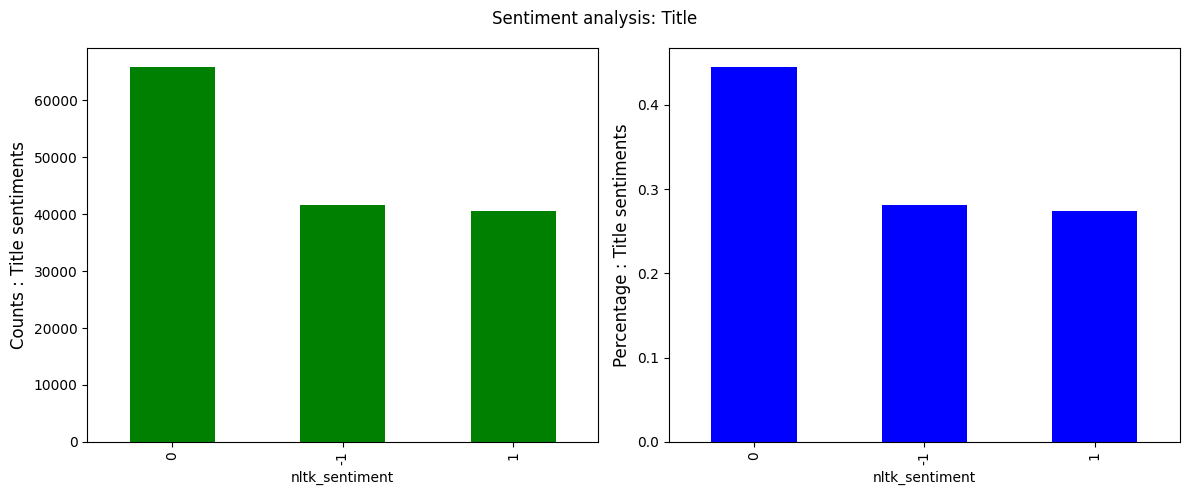

In [9]:
plot_sentiment(wsb_sdf, 'nltk_sentiment', 'Title')

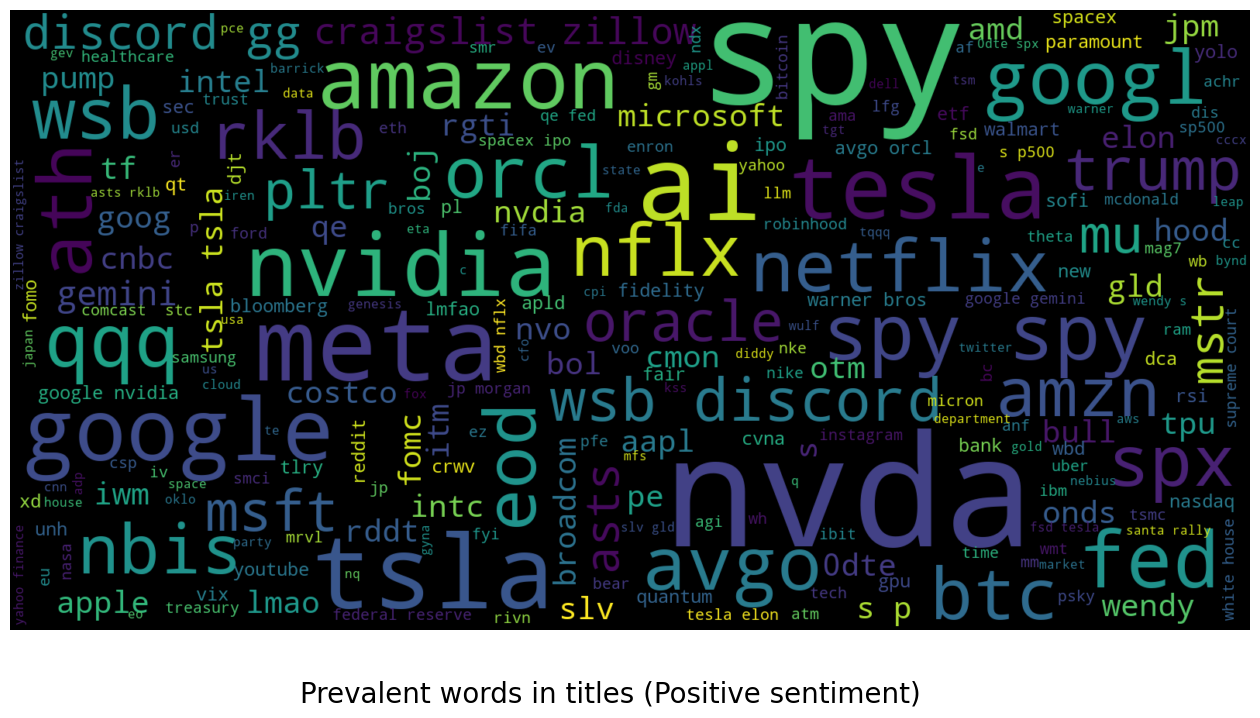

In [10]:
show_wordcloud(wsb_sdf.loc[wsb_sdf['nltk_sentiment']==1, 'ticker'], title = 'Prevalent words in titles (Positive sentiment)')

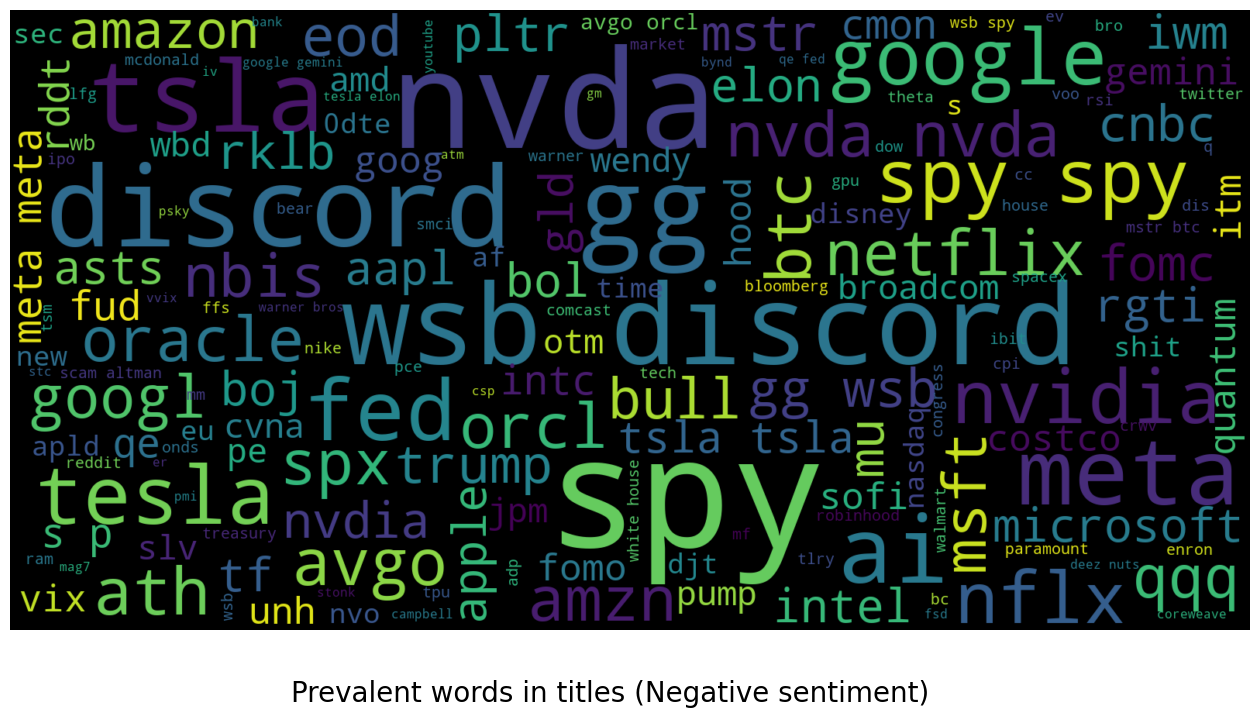

In [11]:
show_wordcloud(wsb_sdf.loc[wsb_sdf['nltk_sentiment']==-1, 'ticker'], title = 'Prevalent words in titles (Negative sentiment)')

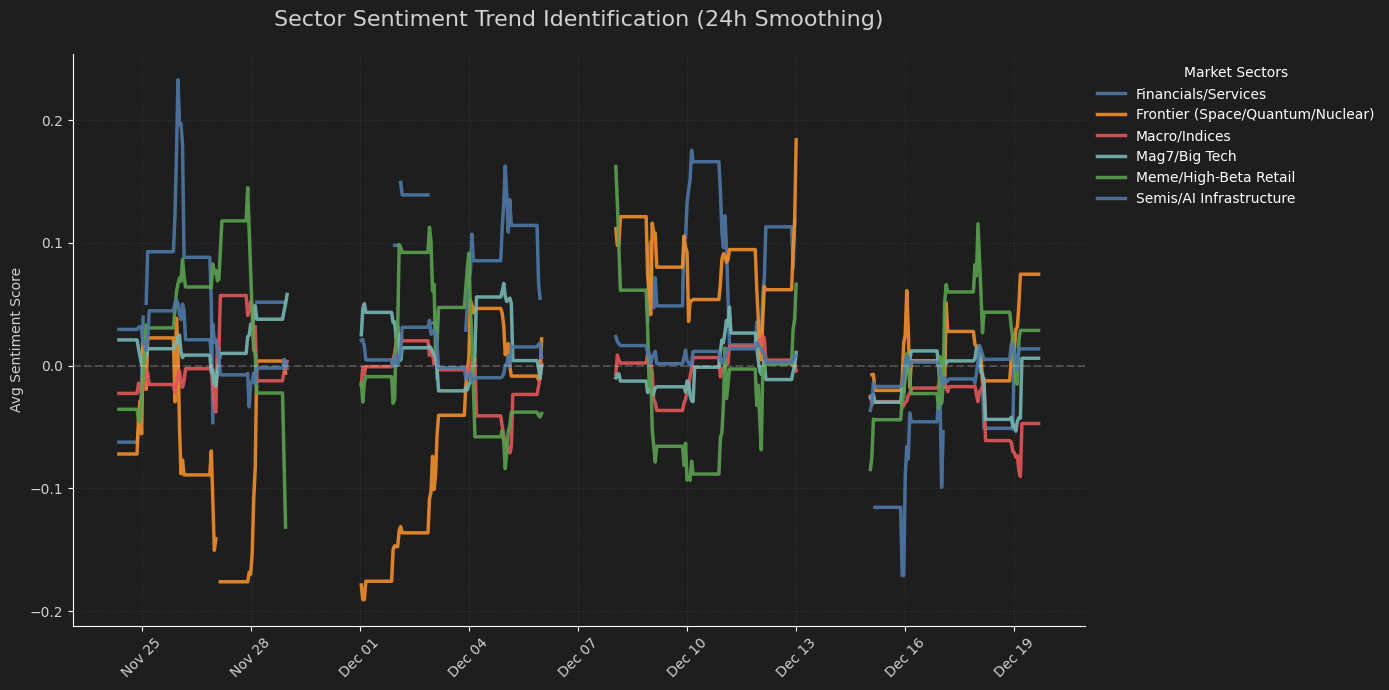

In [12]:
plot_sector_sentiment_trends(wsb_sdf)

## 5. Dataset Consolidation

In [13]:
wsb_sdf.shape, spy_df.shape

((148084, 11), (5850, 6))

In [ ]:
# Save checkpoint
wsb_sdf.to_csv("data/manual_wsb_sdf.csv", index=True)
spy_df.to_csv("data/manual_spy_df.csv", index=True)

# Recover checkpoint
# wsb_sdf = pd.read_csv("data/manual_wsb_sdf.csv")
# spy_df = pd.read_csv("data/manual_spy_df.csv")

In [7]:
merged_df = merge_df(wsb_sdf, spy_df, resample=1)
merged_df = normalize_sentiment(merged_df, sentiment_cols = ['ensemble_sentiment', 'score_finbert'])

# Recover checkpoint
# merged_df = pd.read_csv("data/manual_merged_df.csv")
# merged_df.index = pd.to_datetime(merged_df.index)

/Users/epheriami/Downloads/APS1053H/project/utils/_processing.py:465: FutureWarning: 'T' is deprecated and will be removed in a future version, please use 'min' instead.
  spy = sdf.resample(f'{resample}T').agg(ohlc_dict)
/Users/epheriami/Downloads/APS1053H/project/utils/_processing.py:477: FutureWarning: 'T' is deprecated and will be removed in a future version, please use 'min' instead.
  wsb = wdf.resample(f'{resample}T').agg(sentiment_dict)


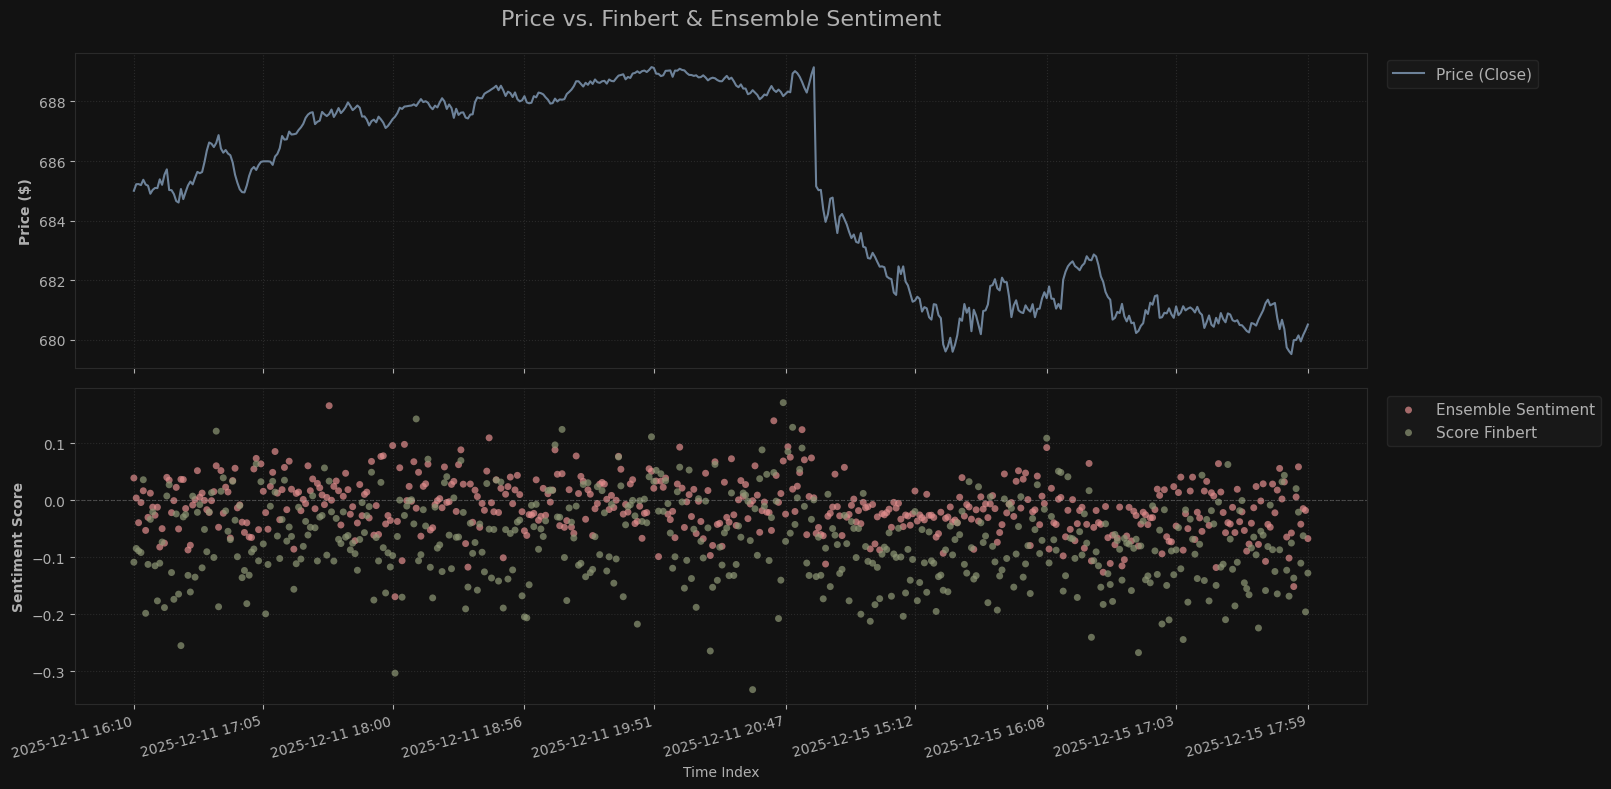

In [11]:
plot_sentiment_vs_price(merged_df.iloc[4000:4500])

In [9]:
merged_df.to_csv("data/manual_merged_df.csv", index=True)

## 6. Strategy and Backtesting

In [18]:
%matplotlib inline
import matplotlib.pyplot as plt
from utils._strategy import *

In [35]:
# Manually cropping the bounds to backtest on bull/bear/flat conditions

# Full range (0, 5850) -- Bull (0, 3850) -- Bear (3850, 5400) -- Flat (1000, 4500)
lower_bound, upper_bound = 0, 3850

plt.figure(figsize=(12, 6))
plt.plot(range(len(merged_df.iloc[lower_bound:upper_bound])), merged_df.iloc[lower_bound:upper_bound]['close'], color='royalblue')

ticks = range(0, upper_bound-lower_bound, (upper_bound-lower_bound)//10)
labels = merged_df.index[ticks].strftime('%Y-%m-%d')
plt.xticks(ticks, labels, rotation=45)

plt.title("Price Movement")
plt.tight_layout()
plt.show()

In [36]:
import backtrader as bt

data_feed = bt.feeds.PandasData(
    dataname=merged_df.iloc[lower_bound:upper_bound],
    datetime=None,
    open='open',
    high='high',
    low='low',
    close='close',
    volume='volume',
    openinterest=None
)

In [37]:
# Baseline strategies
run_and_plot(BuyAndHold, data_feed, "Buy and Hold")
run_and_plot(DollarCostAverageDaily, data_feed, "Dollar Cost Averaging", cash_pct_per_trade=0.05)
run_and_plot(ActiveTechAnalysis, data_feed, "Technical Analysis (EMA, BB, RSI, VWAP)", ema_period=5, rsi_period=14)

--- Running: Buy and Hold ---
Starting Cash:    $100,000.00
Final Value:      $103,787.50
Profit:           3.79%
Sharpe Ratio:     -5.22
Max Drawdown:     0.72%
------------------------
--- Running: Dollar Cost Averaging ---
Starting Cash:    $100,000.00
Final Value:      $100,425.36
Profit:           0.43%
Sharpe Ratio:     -23.53
Max Drawdown:     0.21%
------------------------
--- Running: Technical Analysis (EMA, BB, RSI, VWAP) ---
Starting Cash:    $100,000.00
Final Value:      $101,794.26
Profit:           1.79%
Sharpe Ratio:     -8.20
Max Drawdown:     0.73%
------------------------


In [38]:
# Sentiment-based strategies
run_strategy(SentimentStrategy, merged_df.iloc[lower_bound:upper_bound], "Strategy 1: Pure Sentiment", buy_thresh=0.05, sell_thresh=-0.05)
run_strategy(SentimentTAStrategy, merged_df.iloc[lower_bound:upper_bound], "Strategy 2: Sentiment + Technical Analysis", ema_period=5, rsi_period=14)
run_strategy(InverseSentimentStrategy, merged_df.iloc[lower_bound:upper_bound], "Strategy 3: Inverse Sentiment (Contrarian)", panic_thresh=-0.15, euphoria_thresh=0.15)


========== Strategy 1: Pure Sentiment ==========
Final Value:      $102,026.57
Profit:           2.03%
Sharpe Ratio:     -8.81
Max Drawdown:     0.67%

========== Strategy 2: Sentiment + Technical Analysis ==========
Final Value:      $101,212.10
Profit:           1.21%
Sharpe Ratio:     -9.95
Max Drawdown:     0.60%

========== Strategy 3: Inverse Sentiment (Contrarian) ==========
Final Value:      $100,425.05
Profit:           0.43%
Sharpe Ratio:     -13.83
Max Drawdown:     0.37%
